In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tqdm import tqdm
import copy
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
DOWNLOAD_MNIST=True
train_data=torchvision.datasets.MNIST(root="./mnist/",train=True,download=DOWNLOAD_MNIST)
test_data=torchvision.datasets.MNIST(root="./mnist/",train=False)
X_train=train_data.train_data.numpy()
X_test=test_data.test_data.numpy()
Y_train=train_data.train_labels.numpy()
Y_test=test_data.test_labels.numpy()

In [165]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),                      #scales data to [0,1]
    torchvision.transforms.Normalize((0.1307,), (0.3081,))  #do we need to standardize or just normalize?
])
X_train=transform(X_train)
X_test=transform(X_test)
Y_train_onehot=torch.nn.functional.one_hot(torch.tensor(Y_train))
Y_test_onehot=torch.nn.functional.one_hot(torch.tensor(Y_test))
X_train,X_test=np.moveaxis(X_train.numpy(), 0, -1).reshape((-1,784)),np.moveaxis(X_test.numpy(), 0, -1).reshape((-1,784))
Y_train_onehot,Y_test_onehot=Y_train_onehot.numpy(),Y_test_onehot.numpy()

In [170]:
#for part a and b
train_error=[]
test_error=[]
train_acc=[]
test_acc=[]

EPOCHS=1500

for loop in tqdm(range(5),colour="MAGENTA"):
  tf.random.set_seed(loop+1)
  class simple_ann(Model):
    def __init__(self):
      super().__init__()
      self.layer1=keras.layers.Dense(100,input_shape=[784], activation='relu')
      self.layer2=keras.layers.Dense(10, activation='softmax')
    
    def call(self,x):
      x=self.layer1(x)
      x=self.layer2(x)
      return x
    
  model_simple=simple_ann()
  entropy_loss=keras.losses.CategoricalCrossentropy()
  optimizer=keras.optimizers.SGD(learning_rate=0.1,momentum=0.7)
  train_loss=keras.metrics.Mean(name="train_loss")
  train_accuracy=keras.metrics.CategoricalAccuracy(name="train_accuracy")
  test_loss=keras.metrics.Mean(name="test_loss")
  test_accuracy=keras.metrics.CategoricalAccuracy(name="test_accuracy")
  @tf.function
  def train_step(input,labels):
    with tf.GradientTape() as tape:
      pred=model_simple(input,training=True)
      loss=entropy_loss(labels,pred)
    gradients=tape.gradient(loss,model_simple.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model_simple.trainable_variables))
    train_loss(loss)
    train_accuracy(labels,pred)
  @tf.function
  def test_step(input,labels):
    pred=model_simple(input,training=False)
    test_l=entropy_loss(labels,pred)
    test_loss(test_l)
    test_accuracy(labels,pred)
  train_error_temp,test_error_temp=[],[]
  train_acc_temp,test_acc_temp=[],[]
  for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    train_step(X_train,Y_train_onehot)

    test_step(X_test,Y_test_onehot)

    train_error_temp.append(train_loss.result().numpy())
    test_error_temp.append(test_loss.result().numpy())
    train_acc_temp.append(train_accuracy.result().numpy())
    test_acc_temp.append(test_accuracy.result().numpy())
  train_error.append(train_error_temp)
  test_error.append(test_error_temp)
  train_acc.append(train_acc_temp)
  test_acc.append(test_acc_temp)
  model_simple.save_weights("gdrive/My Drive/ML/weights_seed_{}.h5".format(loop+1))

100%|██████████| 5/5 [08:02<00:00, 96.47s/it]


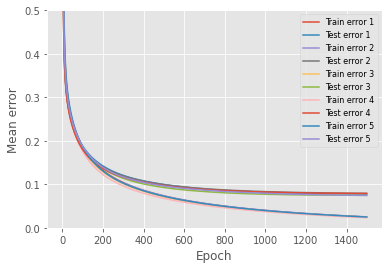

In [171]:
plt.style.use('ggplot')
fig, axs = plt.subplots()
for i in range(len(train_error)):
  axs.plot(train_error[i],label="Train error {}".format(i+1))
  axs.plot(test_error[i],label="Test error {}".format(i+1))
  plt.ylim([0.0,0.5])
  plt.ylabel("Mean error")
  plt.xlabel("Epoch")
  plt.legend(prop={'size': 8})
#For learning_rate=0.1, we can see clear divergence of training and testing errors starting around 200th epoch. Moreover, SGD is much slower than Adam.

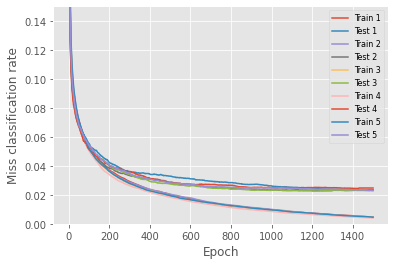

In [172]:
fig, axs = plt.subplots()
for i in range(len(train_error)):
  axs.plot(list(map(lambda x: 1-x,train_acc[i])),label="Train {}".format(i+1))
  axs.plot(list(map(lambda x: 1-x,test_acc[i])),label="Test {}".format(i+1))
  plt.ylim(0.0,0.15)
  plt.ylabel("Miss classification rate")
  plt.xlabel("Epoch")
  plt.legend(prop={'size': 8})
  #The plot has similar traits as cross-entropy error plot. A bit more wiggly than mean error plot.

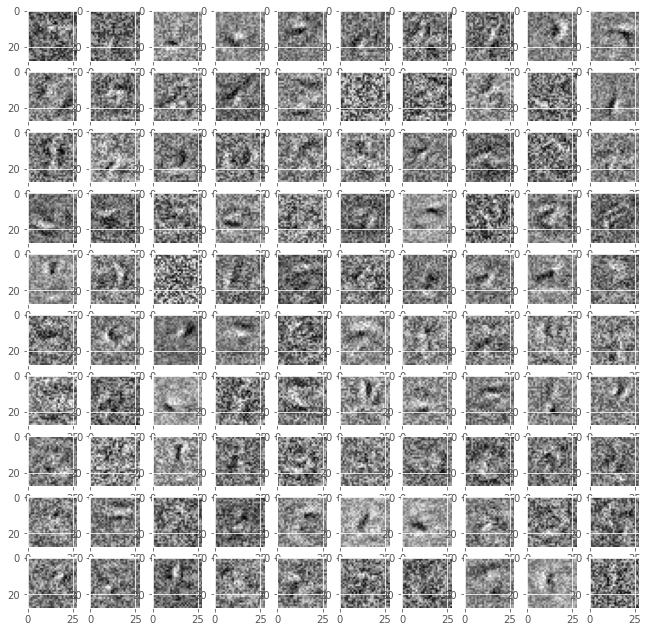

In [173]:
#part c
#judging by mean error, it seems that test error at seed=4 is low. So we load weights from 4.
model_simple.load_weights("gdrive/My Drive/ML/weights_seed_{}.h5".format(4))
weights=model_simple.layers[0].weights[0].numpy().T
fig, axs = plt.subplots(10,10,figsize=(11, 11))
for i,ax in enumerate(axs.ravel()):
    ax.imshow(weights[i].reshape((28,28)),cmap=plt.get_cmap('gray'))
#we are able to observe some features. Some notable ones are zero-looking shapes, horizontal lines, vertical lines, and curvatures. Some look like digits

In [167]:
train1_error=[]
test1_error=[]
train1_acc=[]
test1_acc=[]
EPOCHS=1500

mo_list=[0.0,0.5,0.9]

for j in tqdm(range(len(mo_list))):
  tf.random.set_seed(j)
  class simple_ann(Model):
    def __init__(self):
      super().__init__()
      self.layer1=keras.layers.Dense(100,input_shape=[784], activation='relu')
      self.layer2=keras.layers.Dense(10, activation='softmax')
    
    def call(self,x):
      x=self.layer1(x)
      x=self.layer2(x)
      return x
    
  model_simple=simple_ann()
  entropy_loss=keras.losses.CategoricalCrossentropy()
  optimizer=keras.optimizers.SGD(learning_rate=0.05,momentum=mo_list[j])
  train_loss=keras.metrics.Mean(name="train_loss")
  train_accuracy=keras.metrics.CategoricalAccuracy(name="train_accuracy")
  test_loss=keras.metrics.Mean(name="test_loss")
  test_accuracy=keras.metrics.CategoricalAccuracy(name="test_accuracy")
  @tf.function
  def train_step(input,labels):
    with tf.GradientTape() as tape:
      pred=model_simple(input,training=True)
      loss=entropy_loss(labels,pred)
    gradients=tape.gradient(loss,model_simple.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model_simple.trainable_variables))
    train_loss(loss)
    train_accuracy(labels,pred)
  @tf.function
  def test_step(input,labels):
    pred=model_simple(input,training=False)
    test_l=entropy_loss(labels,pred)
    test_loss(test_l)
    test_accuracy(labels,pred)
  train_error_temp,test_error_temp=[],[]
  train_acc_temp,test_acc_temp=[],[]
  for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    train_step(X_train,Y_train_onehot)

    test_step(X_test,Y_test_onehot)

    train_error_temp.append(train_loss.result().numpy())
    test_error_temp.append(test_loss.result().numpy())
    train_acc_temp.append(train_accuracy.result().numpy())
    test_acc_temp.append(test_accuracy.result().numpy())
  train1_error.append(train_error_temp)
  test1_error.append(test_error_temp)
  train1_acc.append(train_acc_temp)
  test1_acc.append(test_acc_temp)
  model_simple.save_weights("gdrive/My Drive/ML/weights_seed_partd_{}.h5".format(loop+1))

100%|██████████| 3/3 [04:50<00:00, 96.99s/it]


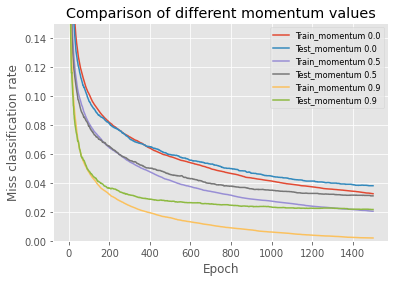

In [169]:
fig, axs = plt.subplots()
for i in range(len(train1_acc)):
  axs.plot(list(map(lambda x: 1-x,train1_acc[i])),label="Train_momentum {}".format(mo_list[i]))
  axs.plot(list(map(lambda x: 1-x,test1_acc[i])),label="Test_momentum {}".format(mo_list[i]))
  plt.ylim(0.0,0.15)
  plt.title("Comparison of different momentum values")
  plt.ylabel("Miss classification rate")
  plt.xlabel("Epoch")
  plt.legend(prop={'size': 8})

#faster converging for higher momentum. It seems that 0.9 is the best since converging faster. 

In [4]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).batch(100)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(100)

In [7]:
#4, part a
train_error=[]
test_error=[]
train_acc=[]
test_acc=[]

EPOCHS=200

for loop in tqdm(range(3),colour="GREEN"):
  tf.random.set_seed(loop+1)
  class simple_cnn(Model):
    def __init__(self):
      super().__init__()
      self.layer1=keras.layers.Conv2D(8, 3, activation='relu')
      self.pool=tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid')
      self.flatten=keras.layers.Flatten()
      self.layer2=keras.layers.Dense(10)
    
    def call(self,x):
      x=self.layer1(x)
      x=self.pool(x)
      x=self.flatten(x)
      x=self.layer2(x)
      return x
    
  model_simple=simple_cnn()
  entropy_loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  optimizer=keras.optimizers.SGD(learning_rate=0.1,momentum=0.9)
  train_loss=keras.metrics.Mean(name="train_loss")
  train_accuracy=keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
  test_loss=keras.metrics.Mean(name="test_loss")
  test_accuracy=keras.metrics.SparseCategoricalAccuracy(name="test_accuracy")
  @tf.function
  def train_step(input,labels):
    with tf.GradientTape() as tape:
      pred=model_simple(input,training=True)
      loss=entropy_loss(labels,pred)
    gradients=tape.gradient(loss,model_simple.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model_simple.trainable_variables))
    train_loss(loss)
    train_accuracy(labels,pred)
  @tf.function
  def test_step(input,labels):
    pred=model_simple(input,training=False)
    test_l=entropy_loss(labels,pred)
    test_loss(test_l)
    test_accuracy(labels,pred)
  train_error_temp,test_error_temp=[],[]
  train_acc_temp,test_acc_temp=[],[]
  for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
      train_step(images, labels)

    for test_images, test_labels in test_ds:
      test_step(test_images, test_labels)

    train_error_temp.append(train_loss.result().numpy())
    test_error_temp.append(test_loss.result().numpy())
    train_acc_temp.append(train_accuracy.result().numpy())
    test_acc_temp.append(test_accuracy.result().numpy())
  train_error.append(train_error_temp)
  test_error.append(test_error_temp)
  train_acc.append(train_acc_temp)
  test_acc.append(test_acc_temp)

100%|██████████| 3/3 [56:34<00:00, 1131.43s/it]


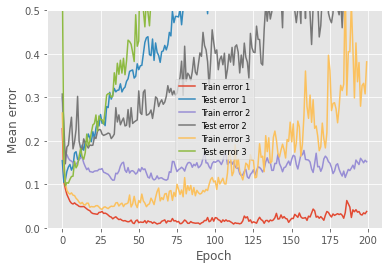

In [13]:
plt.style.use('ggplot')
fig, axs = plt.subplots()
for i in range(len(train_error)):
  axs.plot(train_error[i],label="Train error {}".format(i+1))
  axs.plot(test_error[i],label="Test error {}".format(i+1))
  plt.ylim([0.0,0.5])
  plt.ylabel("Mean error")
  plt.xlabel("Epoch")
  plt.legend(prop={'size': 8})
#I ran out of free gpu on google colab, so I decreased number of conv layers in the model from 32 to 8. I didn't use five seeds due to run time 
# problem. These are the three seeds and it took an hour. We see that convergence is fast with mini-batch inputs. However, error rates are exploding for some training and 
# testing sets, might be due to high learning rate and momentum (which I set as 0.1 and 0.9) and causing divergence from local minima.

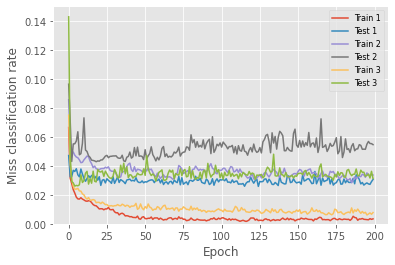

In [10]:
fig, axs = plt.subplots()
for i in range(len(train_error)):
  axs.plot(list(map(lambda x: 1-x,train_acc[i])),label="Train {}".format(i+1))
  axs.plot(list(map(lambda x: 1-x,test_acc[i])),label="Test {}".format(i+1))
  plt.ylim(0.0,0.15)
  plt.ylabel("Miss classification rate")
  plt.xlabel("Epoch")
  plt.legend(prop={'size': 8})
#We see that pattern of accuracy diverges from that of mean error.
#Increase in cross entropy error does not imply decrease in accuracy. As classification threshold is set at 0.5, changes within either side doesn't affect accuracy.

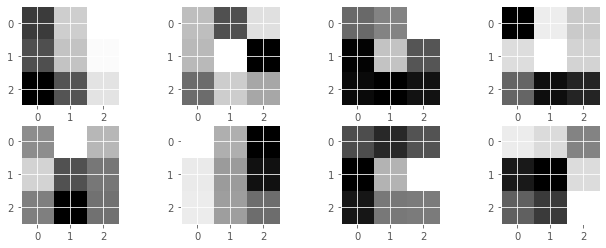

In [46]:
weights_cnn_simple=copy.deepcopy(model_simple.layers[0].weights[0].numpy().T)
fig, axs = plt.subplots(2,4,figsize=(11, 4))
for i,ax in enumerate(axs.ravel()):
    ax.imshow(weights_cnn_simple[i].flatten().reshape((3,3)),cmap=plt.get_cmap('gray'))
#we can see that there are color patterns.

In [48]:
trainc_error=[]
testc_error=[]
trainc_acc=[]
testc_acc=[]


EPOCHS=200


tf.random.set_seed(10)
class simple_cnn(Model):
    def __init__(self):
        super().__init__()
        self.layer1=keras.layers.Conv2D(16, 3, activation='relu')
        self.pool=tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid')
        self.flatten=keras.layers.Flatten()
        self.layer2=keras.layers.Dense(10)

    def call(self,x):
        x=self.layer1(x)
        x=self.pool(x)
        x=self.flatten(x)
        x=self.layer2(x)
        return x

model_simple=simple_cnn()
entropy_loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=keras.optimizers.SGD(learning_rate=0.01,momentum=0.5)
train_loss=keras.metrics.Mean(name="train_loss")
train_accuracy=keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
test_loss=keras.metrics.Mean(name="test_loss")
test_accuracy=keras.metrics.SparseCategoricalAccuracy(name="test_accuracy")
@tf.function
def train_step(input,labels):
    with tf.GradientTape() as tape:
        pred=model_simple(input,training=True)
        loss=entropy_loss(labels,pred)
    gradients=tape.gradient(loss,model_simple.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model_simple.trainable_variables))
    train_loss(loss)
    train_accuracy(labels,pred)
@tf.function
def test_step(input,labels):
    pred=model_simple(input,training=False)
    test_l=entropy_loss(labels,pred)
    test_loss(test_l)
    test_accuracy(labels,pred)
for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
        
    trainc_error.append(train_loss.result().numpy())
    testc_error.append(test_loss.result().numpy())
    trainc_acc.append(train_accuracy.result().numpy())
    testc_acc.append(test_accuracy.result().numpy())

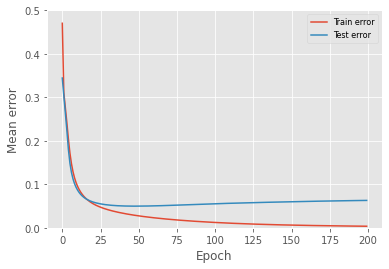

In [55]:
fig, axs = plt.subplots()
axs.plot(trainc_error,label="Train error")
axs.plot(testc_error,label="Test error")
plt.ylim([0.0,0.5])
plt.ylabel("Mean error")
plt.xlabel("Epoch")
plt.legend(prop={'size': 8})
#with proper number of conv filters (16), learning rate (0.01), and momentum (0.5), we see error plot is much more reasonable. Testing error is increasing due to overfit.

Test accuracy is 0.9837


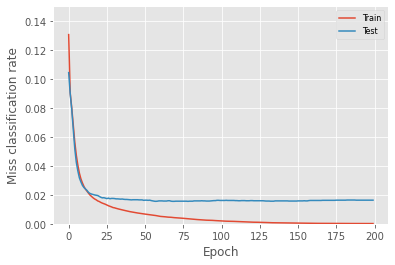

In [72]:
fig, axs = plt.subplots()
axs.plot(list(map(lambda x: 1-x,trainc_acc)),label="Train")
axs.plot(list(map(lambda x: 1-x,testc_acc)),label="Test")
plt.ylim(0.0,0.15)
plt.ylabel("Miss classification rate")
plt.xlabel("Epoch")
plt.legend(prop={'size': 8})
print("Test accuracy is {:.4f}".format(testc_acc[-1]))
#Miss classification rate drops below 0.02. 

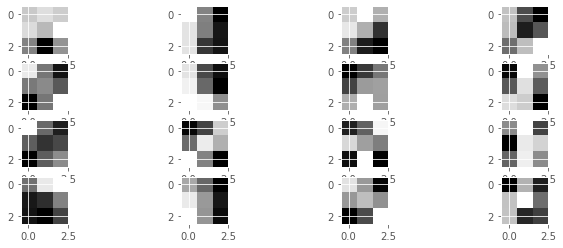

In [58]:
weights_cnn=model_simple.layers[0].weights[0].numpy().T
fig, axs = plt.subplots(4,4,figsize=(11, 4))
for i,ax in enumerate(axs.ravel()):
    ax.imshow(weights_cnn[i].flatten().reshape((3,3)),cmap=plt.get_cmap('gray'))
#more patterns.

In [77]:
#part 5
#for image classification, CNN is more reasonable to use than ANN and LSTM since the structure is more suitable. So we stick to CNN.
trainb_error=[]
testb_error=[]
trainb_acc=[]
testb_acc=[]


EPOCHS=200


tf.random.set_seed(10)
class cnn(Model):
    def __init__(self):
        super().__init__()
        self.layer1=keras.layers.Conv2D(16, 5, activation='relu')
        self.b1=keras.layers.BatchNormalization()
        self.pool=keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid')
        self.drop=keras.layers.Dropout(0.2)
        self.flatten=keras.layers.Flatten()
        self.b2=keras.layers.BatchNormalization()
        self.dense=keras.layers.Dense(128,activation="relu",kernel_regularizer=keras.regularizers.L2(0.005),bias_regularizer=keras.regularizers.L2(0.005))
        self.drop=keras.layers.Dropout(0.1)
        self.b3=keras.layers.BatchNormalization()
        self.layer2=keras.layers.Dense(10)

    def call(self,x):
        x=self.layer1(x)
        x=self.b1(x)
        x=self.pool(x)
        x=self.drop(x)
        x=self.flatten(x)
        x=self.b2(x)
        x=self.dense(x)
        x=self.drop(x)
        x=self.b3(x)
        x=self.layer2(x)
        return x

model_simple=cnn()
entropy_loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=keras.optimizers.Adam(learning_rate=0.01)
train_loss=keras.metrics.Mean(name="train_loss")
train_accuracy=keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
test_loss=keras.metrics.Mean(name="test_loss")
test_accuracy=keras.metrics.SparseCategoricalAccuracy(name="test_accuracy")
@tf.function
def train_step(input,labels):
    with tf.GradientTape() as tape:
        pred=model_simple(input,training=True)
        loss=entropy_loss(labels,pred)
    gradients=tape.gradient(loss,model_simple.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model_simple.trainable_variables))
    train_loss(loss)
    train_accuracy(labels,pred)
@tf.function
def test_step(input,labels):
    pred=model_simple(input,training=False)
    test_l=entropy_loss(labels,pred)
    test_loss(test_l)
    test_accuracy(labels,pred)
for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
        
    trainb_error.append(train_loss.result().numpy())
    testb_error.append(test_loss.result().numpy())
    trainb_acc.append(train_accuracy.result().numpy())
    testb_acc.append(test_accuracy.result().numpy())


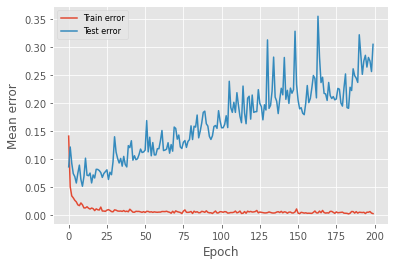

In [80]:
fig, axs = plt.subplots()
axs.plot(trainb_error,label="Train error")
axs.plot(testb_error,label="Test error")
plt.ylabel("Mean error")
plt.xlabel("Epoch")
plt.legend(prop={'size': 8})
#Took an hour to train
#We use Adam optimizer, with deeper CNN, and regularizations.
#the best model, we do see some overfitting. Might want to use early stopping.

Test accuracy is 0.9904


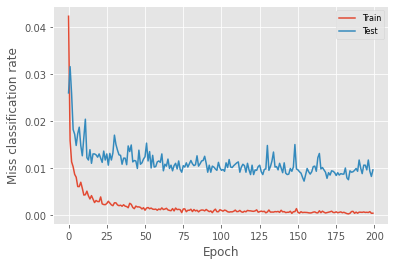

In [79]:
fig, axs = plt.subplots()
axs.plot(list(map(lambda x: 1-x,trainb_acc)),label="Train")
axs.plot(list(map(lambda x: 1-x,testb_acc)),label="Test")
plt.ylabel("Miss classification rate")
plt.xlabel("Epoch")
plt.legend(prop={'size': 8})
print("Test accuracy is {:.4f}".format(testb_acc[-1]))
#despite overfitting in later epochs, miss classification drops to around 0.01 very early in epochs, just around when overfitting occurs.

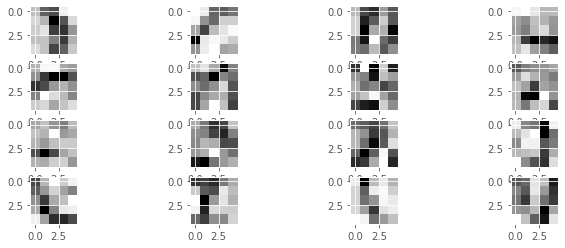

In [82]:
weights_b=model_simple.layers[0].weights[0].numpy().T
fig, axs = plt.subplots(4,4,figsize=(11, 4))
for i,ax in enumerate(axs.ravel()):
    ax.imshow(weights_b[i].flatten().reshape((5,5)),cmap=plt.get_cmap('gray'))

In [99]:
#part 5
train=np.genfromtxt("C:\\Users\\12580\\Desktop\\train.txt", delimiter=',')
val=np.genfromtxt("C:\\Users\\12580\\Desktop\\val.txt", delimiter=',')
test=np.genfromtxt("C:\\Users\\12580\\Desktop\\test.txt", delimiter=',')

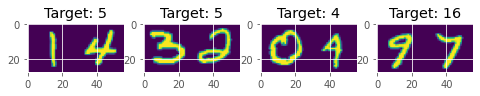

In [182]:
#problem 6
fig, axs = plt.subplots(1,4,figsize=(8, 8))
for i,ax in enumerate(axs):
    ax.imshow(train[i,:-1].reshape((28,56)))
    ax.set_title("Target: {:.0f}".format(train[i,-1]))
#This is a summation problem. Two digits sum to target.

In [244]:
#problem 7
train_X,train_y=train[:,:-1].reshape((len(train),28,56,1)),tf.one_hot(train[:,-1],19)
test_X,test_y=test[:,:-1].reshape((len(test),28,56,1)),tf.one_hot(test[:,-1],19)
val_X,val_y=val[:,:-1].reshape((len(val),28,56,1)),tf.one_hot(val[:,-1],19)

In [379]:
train7_acc=[]
train7_loss=[]
val7_acc=[]
val7_loss=[]
test_results=[]
for i in tqdm(range(3)):
    tf.random.set_seed(i)
    model = keras.models.Sequential([
        keras.layers.Conv2D(16,5, activation='relu'),
        keras.layers.Dropout(0.25),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(2,2)),
        keras.layers.Dropout(0.25),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(32,3, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(2,2)),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(19,activation="softmax")])
    model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(learning_rate=0.0003),metrics=[keras.metrics.CategoricalAccuracy("acc")])
    callback=keras.callbacks.EarlyStopping(monitor="val_loss",patience=5, restore_best_weights=True)
    history=model.fit(train_X, train_y, epochs=150, batch_size=100, validation_data=(val_X, val_y),verbose=False, callbacks=[callback])
    val7_acc.append(history.history["val_acc"])
    val7_loss.append(history.history["val_loss"])
    train7_loss.append(history.history["loss"])
    train7_acc.append(history.history["acc"])
    test_results.append(model.evaluate(test_X,test_y))
    np.save("C:\\Users\\12580\\Desktop\\model_w{}.npy".format(i),model.layers[0].weights[0].numpy().T)

  0%|          | 0/3 [00:00<?, ?it/s]

157/157 [==============================] - 1s 6ms/step - loss: 0.3569 - acc: 0.8962


 33%|███▎      | 1/3 [06:27<12:54, 387.10s/it]

157/157 [==============================] - 1s 6ms/step - loss: 0.2889 - acc: 0.9160


 67%|██████▋   | 2/3 [15:54<08:13, 493.14s/it]

157/157 [==============================] - 1s 6ms/step - loss: 0.3725 - acc: 0.8898


100%|██████████| 3/3 [22:31<00:00, 450.46s/it]


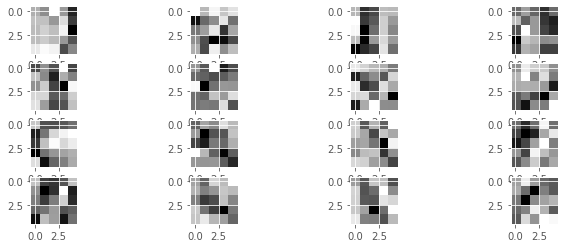

In [380]:
weights=np.load("C:\\Users\\12580\\Desktop\\model_w1.npy")
fig, axs = plt.subplots(4,4,figsize=(11, 4))
for i,ax in enumerate(axs.ravel()):
    ax.imshow(weights[i].flatten().reshape((5,5)),cmap=plt.get_cmap('gray'))
#We see that the secod model has highest accuracy, so load the weights. Patterns here are not completely fuzzy but still unreadable by human. 

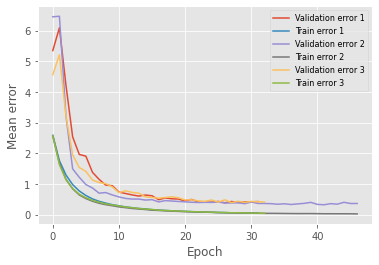

In [386]:
fig, axs = plt.subplots()
for i in range(len(val7_loss)):
  axs.plot(val7_loss[i],label="Validation error {}".format(i+1))
  axs.plot(train7_loss[i],label="Train error {}".format(i+1))
  plt.ylabel("Mean error")
  plt.xlabel("Epoch")
  plt.legend(prop={'size': 8})
#Eearly stopping introduced. Validation error higher as expected.

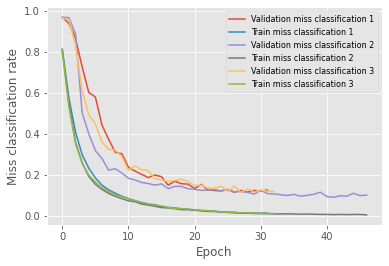

In [403]:
fig, axs = plt.subplots()
for i in range(len(val7_acc)):
  axs.plot(list(map(lambda x: 1-x,val7_acc[i])),label="Validation miss classification {}".format(i+1))
  axs.plot(list(map(lambda x: 1-x,train7_acc[i])),label="Train miss classification {}".format(i+1))
  plt.ylabel("Miss classification rate")
  plt.xlabel("Epoch")
  plt.legend(prop={'size': 8})
#model performance don't vary by a lot for different seeds.

In [397]:
print("Generalization error is {:.4f}".format(test_results[1][0]))
print("Generalization miss classification rate is {:.4f}".format(1-test_results[1][1]))
#test error is higher because the task is harder. We not only need to recognize two digits at once but need to learn a summation relation. So it's unlikely that test
#error here will be that of MNIST data.

Generalization error is 0.2889
Generalization miss classification rate is 0.0840


In [400]:
train7b_acc=[]
train7b_loss=[]
val7b_acc=[]
val7b_loss=[]
testb_results=[]
i=1
tf.random.set_seed(i)
model = keras.models.Sequential([
    keras.layers.Conv2D(16,5, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.25),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32,5, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(19,activation="softmax")])
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(learning_rate=0.0003),metrics=[keras.metrics.CategoricalAccuracy("acc")])
callback=keras.callbacks.EarlyStopping(monitor="val_loss",patience=4, restore_best_weights=True)
history=model.fit(train_X, train_y, epochs=150, batch_size=100, validation_data=(val_X, val_y),verbose=False, callbacks=[callback])
val7b_acc.append(history.history["val_acc"])
val7b_loss.append(history.history["val_loss"])
train7b_loss.append(history.history["loss"])
train7b_acc.append(history.history["acc"])
testb_results.append(model.evaluate(test_X,test_y))
np.save("C:\\Users\\12580\\Desktop\\modelb_w{}.npy".format(i),model.layers[0].weights[0].numpy().T)

157/157 [==============================] - 1s 6ms/step - loss: 0.2275 - acc: 0.9252


In [406]:
print("Generalization error is {:.4f}".format(testb_results[0][0]))
print("Generalization miss classification rate is {:.4f}".format(1-testb_results[0][1]))
print("Generalization accuracy is {:.4f}".format(testb_results[0][1]))
#This model is doing better, but not close to accuracy of 0.99.

Generalization error is 0.2275
Generalization miss classification rate is 0.0748
Generalization accuracy is 0.9252


In [414]:
train_X1=train[:,:-1].reshape((len(train),28,56))
test_X1=test[:,:-1].reshape((len(test),28,56))
val_X1=val[:,:-1].reshape((len(val),28,56))

In [416]:
trainlstm_acc=[]
trainlstm_loss=[]
vallstm_acc=[]
vallstm_loss=[]
testlstm_results=[]
for i in tqdm(range(3)):
    tf.random.set_seed(i)
    model = keras.models.Sequential([
        keras.layers.LSTM(30,activation="relu"),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(19,activation="softmax")])
    model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(learning_rate=0.0003),metrics=[keras.metrics.CategoricalAccuracy("acc")])
    callback=keras.callbacks.EarlyStopping(monitor="val_loss",patience=5, restore_best_weights=True)
    history=model.fit(train_X1, train_y, epochs=150, batch_size=100, validation_data=(val_X1, val_y),verbose=False, callbacks=[callback])
    vallstm_acc.append(history.history["val_acc"])
    vallstm_loss.append(history.history["val_loss"])
    trainlstm_loss.append(history.history["loss"])
    trainlstm_acc.append(history.history["acc"])
    testlstm_results.append(model.evaluate(test_X1,test_y))
    np.save("C:\\Users\\12580\\Desktop\\lstm_w{}.npy".format(i),model.layers[0].weights[0].numpy().T)

  0%|          | 0/3 [00:00<?, ?it/s]

157/157 [==============================] - 1s 2ms/step - loss: 1.2501 - acc: 0.6082


 33%|███▎      | 1/3 [01:53<03:47, 113.76s/it]

157/157 [==============================] - 1s 2ms/step - loss: 1.2932 - acc: 0.5874


 67%|██████▋   | 2/3 [03:40<01:49, 109.88s/it]

157/157 [==============================] - 0s 2ms/step - loss: 1.3283 - acc: 0.5762


100%|██████████| 3/3 [05:41<00:00, 113.73s/it]


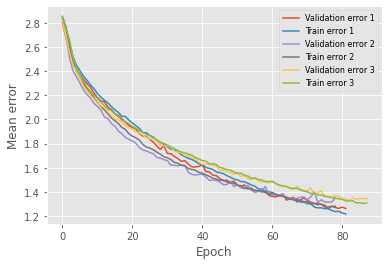

In [417]:
fig, axs = plt.subplots()
for i in range(len(val7_loss)):
  axs.plot(vallstm_loss[i],label="Validation error {}".format(i+1))
  axs.plot(trainlstm_loss[i],label="Train error {}".format(i+1))
  plt.ylabel("Mean error")
  plt.xlabel("Epoch")
  plt.legend(prop={'size': 8})
#Theoretically, LSTM does not have advantage for non-sequential related tasks. 
#Apparently model is not deep enough to carry out our task. The model is underfitting.

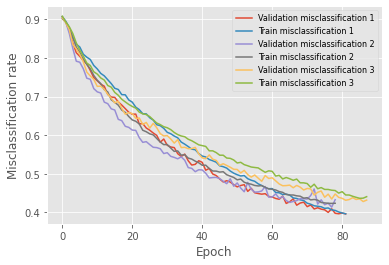

In [446]:
fig, axs = plt.subplots()
for i in range(len(val7_acc)):
  axs.plot(list(map(lambda x: 1-x,vallstm_acc[i])),label="Validation misclassification {}".format(i+1))
  axs.plot(list(map(lambda x: 1-x,trainlstm_acc[i])),label="Train misclassification {}".format(i+1))
  plt.ylabel("Misclassification")
  plt.xlabel("Epoch")
  plt.legend(prop={'size': 8})
#Some of the validation miss classfication is actually lower than training

In [425]:
print("Generalization error is {:.4f}".format(testlstm_results[0][0]))
print("Generalization miss classification rate is {:.4f}".format(1-testlstm_results[0][1]))

Generalization error is 1.2501
Generalization miss classification rate is 0.3918


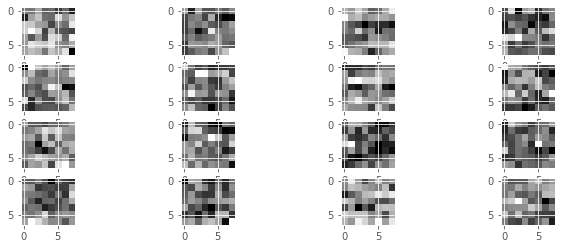

In [424]:
weights=np.load("C:\\Users\\12580\\Desktop\\lstm_w0.npy")       #seed 0 has the best result
fig, axs = plt.subplots(4,4,figsize=(11, 4))
for i,ax in enumerate(axs.ravel()):
    ax.imshow(weights[i].flatten().reshape((7,8)),cmap=plt.get_cmap('gray'))
#More blurry than CNN plots.

In [437]:
trainlstm1_acc=[]
trainlstm1_loss=[]
vallstm1_acc=[]
vallstm1_loss=[]
testlstm1_results=[]

tf.random.set_seed(0)
model = keras.models.Sequential([
    keras.layers.Bidirectional(keras.layers.LSTM(100,activation="relu",return_sequences=True)),
    keras.layers.Dropout(0.25),
    keras.layers.Bidirectional(keras.layers.LSTM(100,activation="relu")),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(19,activation="softmax")])
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(learning_rate=0.001),metrics=[keras.metrics.CategoricalAccuracy("acc")])
callback=keras.callbacks.EarlyStopping(monitor="val_loss",patience=5, restore_best_weights=True)
history=model.fit(train_X1, train_y, epochs=150, batch_size=100, validation_data=(val_X1, val_y),verbose=False, callbacks=[callback])
vallstm1_acc.append(history.history["val_acc"])
vallstm1_loss.append(history.history["val_loss"])
trainlstm1_loss.append(history.history["loss"])
trainlstm1_acc.append(history.history["acc"])
testlstm1_results.append(model.evaluate(test_X1,test_y))

157/157 [==============================] - 2s 12ms/step - loss: 0.4333 - acc: 0.8896


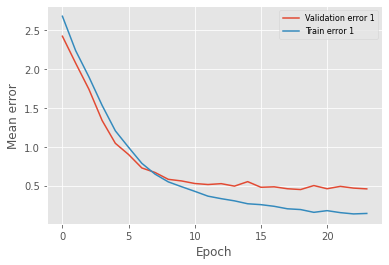

In [439]:
fig, axs = plt.subplots()
for i in range(len(vallstm1_loss)):
  axs.plot(vallstm1_loss[i],label="Validation error {}".format(i+1))
  axs.plot(trainlstm1_loss[i],label="Train error {}".format(i+1))
  plt.ylabel("Mean error")
  plt.xlabel("Epoch")
  plt.legend(prop={'size': 8})

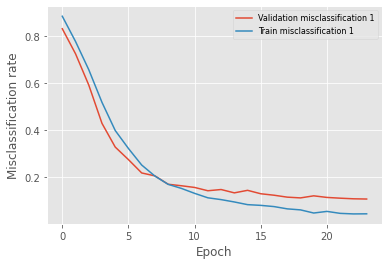

In [444]:
fig, axs = plt.subplots()
for i in range(len(vallstm1_acc)):
  axs.plot(list(map(lambda x: 1-x,vallstm1_acc[i])),label="Validation misclassification {}".format(i+1))
  axs.plot(list(map(lambda x: 1-x,trainlstm1_acc[i])),label="Train misclassification {}".format(i+1))
  plt.ylabel("Misclassification rate")
  plt.xlabel("Epoch")
  plt.legend(prop={'size': 8})

In [441]:
print("Generalization error is {:.4f}".format(testlstm1_results[0][0]))
print("Generalization miss classification rate is {:.4f}".format(1-testlstm1_results[0][1]))
print("Generalization accuracy is {:.4f}".format(testlstm1_results[0][1]))

Generalization error is 0.4333
Generalization miss classification rate is 0.1104
Generalization accuracy is 0.8896
